In [ ]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 136 (delta 46), reused 52 (delta 26), pack-reused 55
Receiving objects: 100% (136/136), 195.29 KiB | 6.10 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [ ]:
cd lag-llama

/content/lag-llama


In [ ]:
pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt to /root/.cache/huggingface/hub/tmpows1p2hw
lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 125MB/s]
/content/lag-llama/lag-llama.ckpt


In [ ]:

from itertools import islice
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from lag_llama.gluon.estimator import LagLlamaEstimator

In [ ]:
dataset = get_dataset("australian_electricity_demand")

backtest_dataset = dataset.test
prediction_length = dataset.metadata.prediction_length
context_length = 3 * prediction_length

Download australian_electricity_demand_dataset.zip:: 5.51MB [00:02, 2.25MB/s]
creating json files: 100%|██████████| 5/5 [00:00<00:00, 9047.25it/s]


In [ ]:
type(dataset)

gluonts.dataset.common.TrainDatasets

In [ ]:
dataset.metadata

MetaData(freq='0.5H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='5')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=60)

In [ ]:
len(dataset.test)

5

In [ ]:
type(dataset.test)

gluonts.itertools.Map

In [ ]:
dataset.test

Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x79af4cdb5420>, iterable=JsonLinesFile(path=PosixPath('/root/.gluonts/datasets/australian_electricity_demand/test/data.json.gz'), start=0, n=None, line_starts=[0, 3035943, 5989208, 9004919, 11859716]))

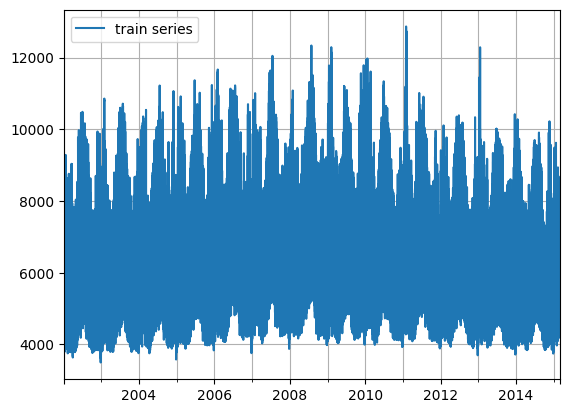

In [ ]:
from gluonts.dataset.util import to_pandas
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

In [ ]:
train_series.shape

(230676,)

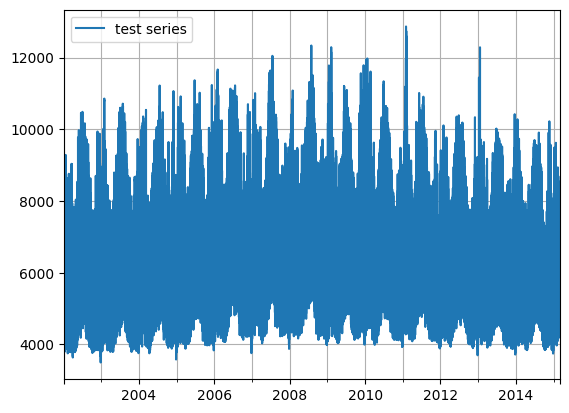

In [ ]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)

test_series.plot()
plt.grid(which="both")
plt.legend(["test series"], loc="upper left")
plt.show()

In [ ]:
test_series.shape

(230736,)

In [ ]:
test_series.head()

2002-01-01 00:00    5714.044922
2002-01-01 00:30    5360.188965
2002-01-01 01:00    5014.834961
2002-01-01 01:30    4602.755371
2002-01-01 02:00    4285.179688
Freq: 30T, dtype: float32

In [ ]:
solar_data = get_dataset("solar-energy")

In [ ]:
solar_data.metadata

MetaData(freq='1H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [ ]:
from gluonts.dataset.util import to_pandas
entry = next(iter(solar_data.train))
train_series = to_pandas(entry)

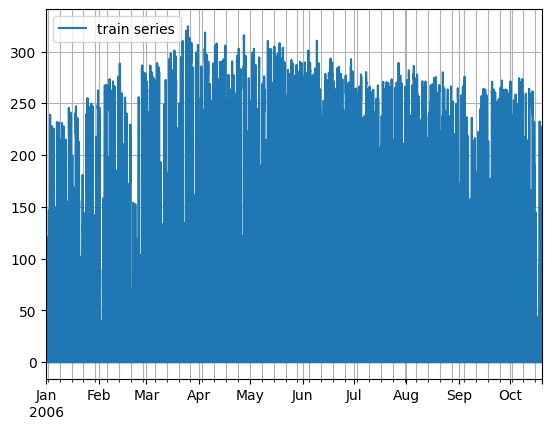

In [ ]:
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

In [ ]:
train_series.shape

(7009,)

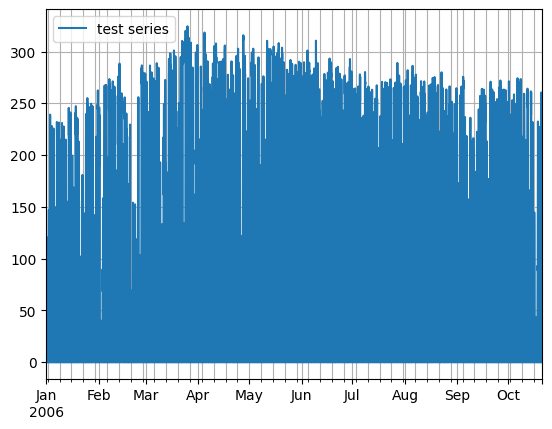

In [ ]:
entry = next(iter(solar_data.test))
test_series = to_pandas(entry)

test_series.plot()
plt.grid(which="both")
plt.legend(["test series"], loc="upper left")
plt.show()

In [ ]:
train_series.shape

(7009,)

In [ ]:

ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cuda:0'))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

In [ ]:
estimator_args

{'input_size': 1,
 'context_length': 32,
 'max_context_length': 2048,
 'lags_seq': [0,
  7,
  8,
  10,
  11,
  12,
  13,
  14,
  19,
  20,
  21,
  22,
  23,
  24,
  26,
  27,
  28,
  29,
  30,
  34,
  35,
  36,
  46,
  47,
  48,
  50,
  51,
  52,
  55,
  57,
  58,
  59,
  60,
  61,
  70,
  71,
  72,
  83,
  94,
  95,
  96,
  102,
  103,
  104,
  117,
  118,
  119,
  120,
  121,
  142,
  143,
  144,
  154,
  155,
  156,
  166,
  167,
  168,
  177,
  178,
  179,
  180,
  181,
  334,
  335,
  336,
  362,
  363,
  364,
  502,
  503,
  504,
  670,
  671,
  672,
  718,
  719,
  720,
  726,
  727,
  728,
  1090,
  1091,
  1092],
 'n_layer': 8,
 'n_embd_per_head': 16,
 'n_head': 9,
 'scaling': 'robust',
 'distr_output': gluonts.torch.distributions.studentT.StudentTOutput(),
 'num_parallel_samples': 100,
 'rope_scaling': None,
 'time_feat': True,
 'dropout': 0.0}

In [ ]:

estimator = LagLlamaEstimator(
    ckpt_path="lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,

    # estimator args
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
)

lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
  dataset=backtest_dataset,
  predictor=predictor)

In [ ]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [ ]:
evaluator = Evaluator()

agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 5it [00:00, 86.03it/s]


In [ ]:
agg_metrics

{'MSE': 289862.8353125,
 'abs_error': 74986.51586914062,
 'abs_target_sum': 998149.748046875,
 'abs_target_mean': 3327.165826822916,
 'seasonal_error': 238.53778569914635,
 'MASE': 1.2062642567407857,
 'MAPE': 0.11604634761810302,
 'sMAPE': 0.10368810653686525,
 'MSIS': 29.102933807998035,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 103881.35757446289,
 'Coverage[0.1]': 0.05333333333333333,
 'QuantileLoss[0.2]': 111179.41470336914,
 'Coverage[0.2]': 0.13666666666666666,
 'QuantileLoss[0.3]': 101043.62366027833,
 'Coverage[0.3]': 0.23000000000000004,
 'QuantileLoss[0.4]': 81575.4236328125,
 'Coverage[0.4]': 0.3433333333333334,
 'QuantileLoss[0.5]': 74986.51434326172,
 'Coverage[0.5]': 0.5766666666666667,
 'QuantileLoss[0.6]': 78293.7121459961,
 'Coverage[0.6]': 0.7666666666666667,
 'QuantileLoss[0.7]': 81375.77168579104,
 'Coverage[0.7]': 0.8799999999999999,
 'QuantileLoss[0.8]': 79220.24978027343,
 'Coverage[0.8]': 0.96,
 'QuantileLoss[0.9]': 72296.61152343749,
 'Coverage[0

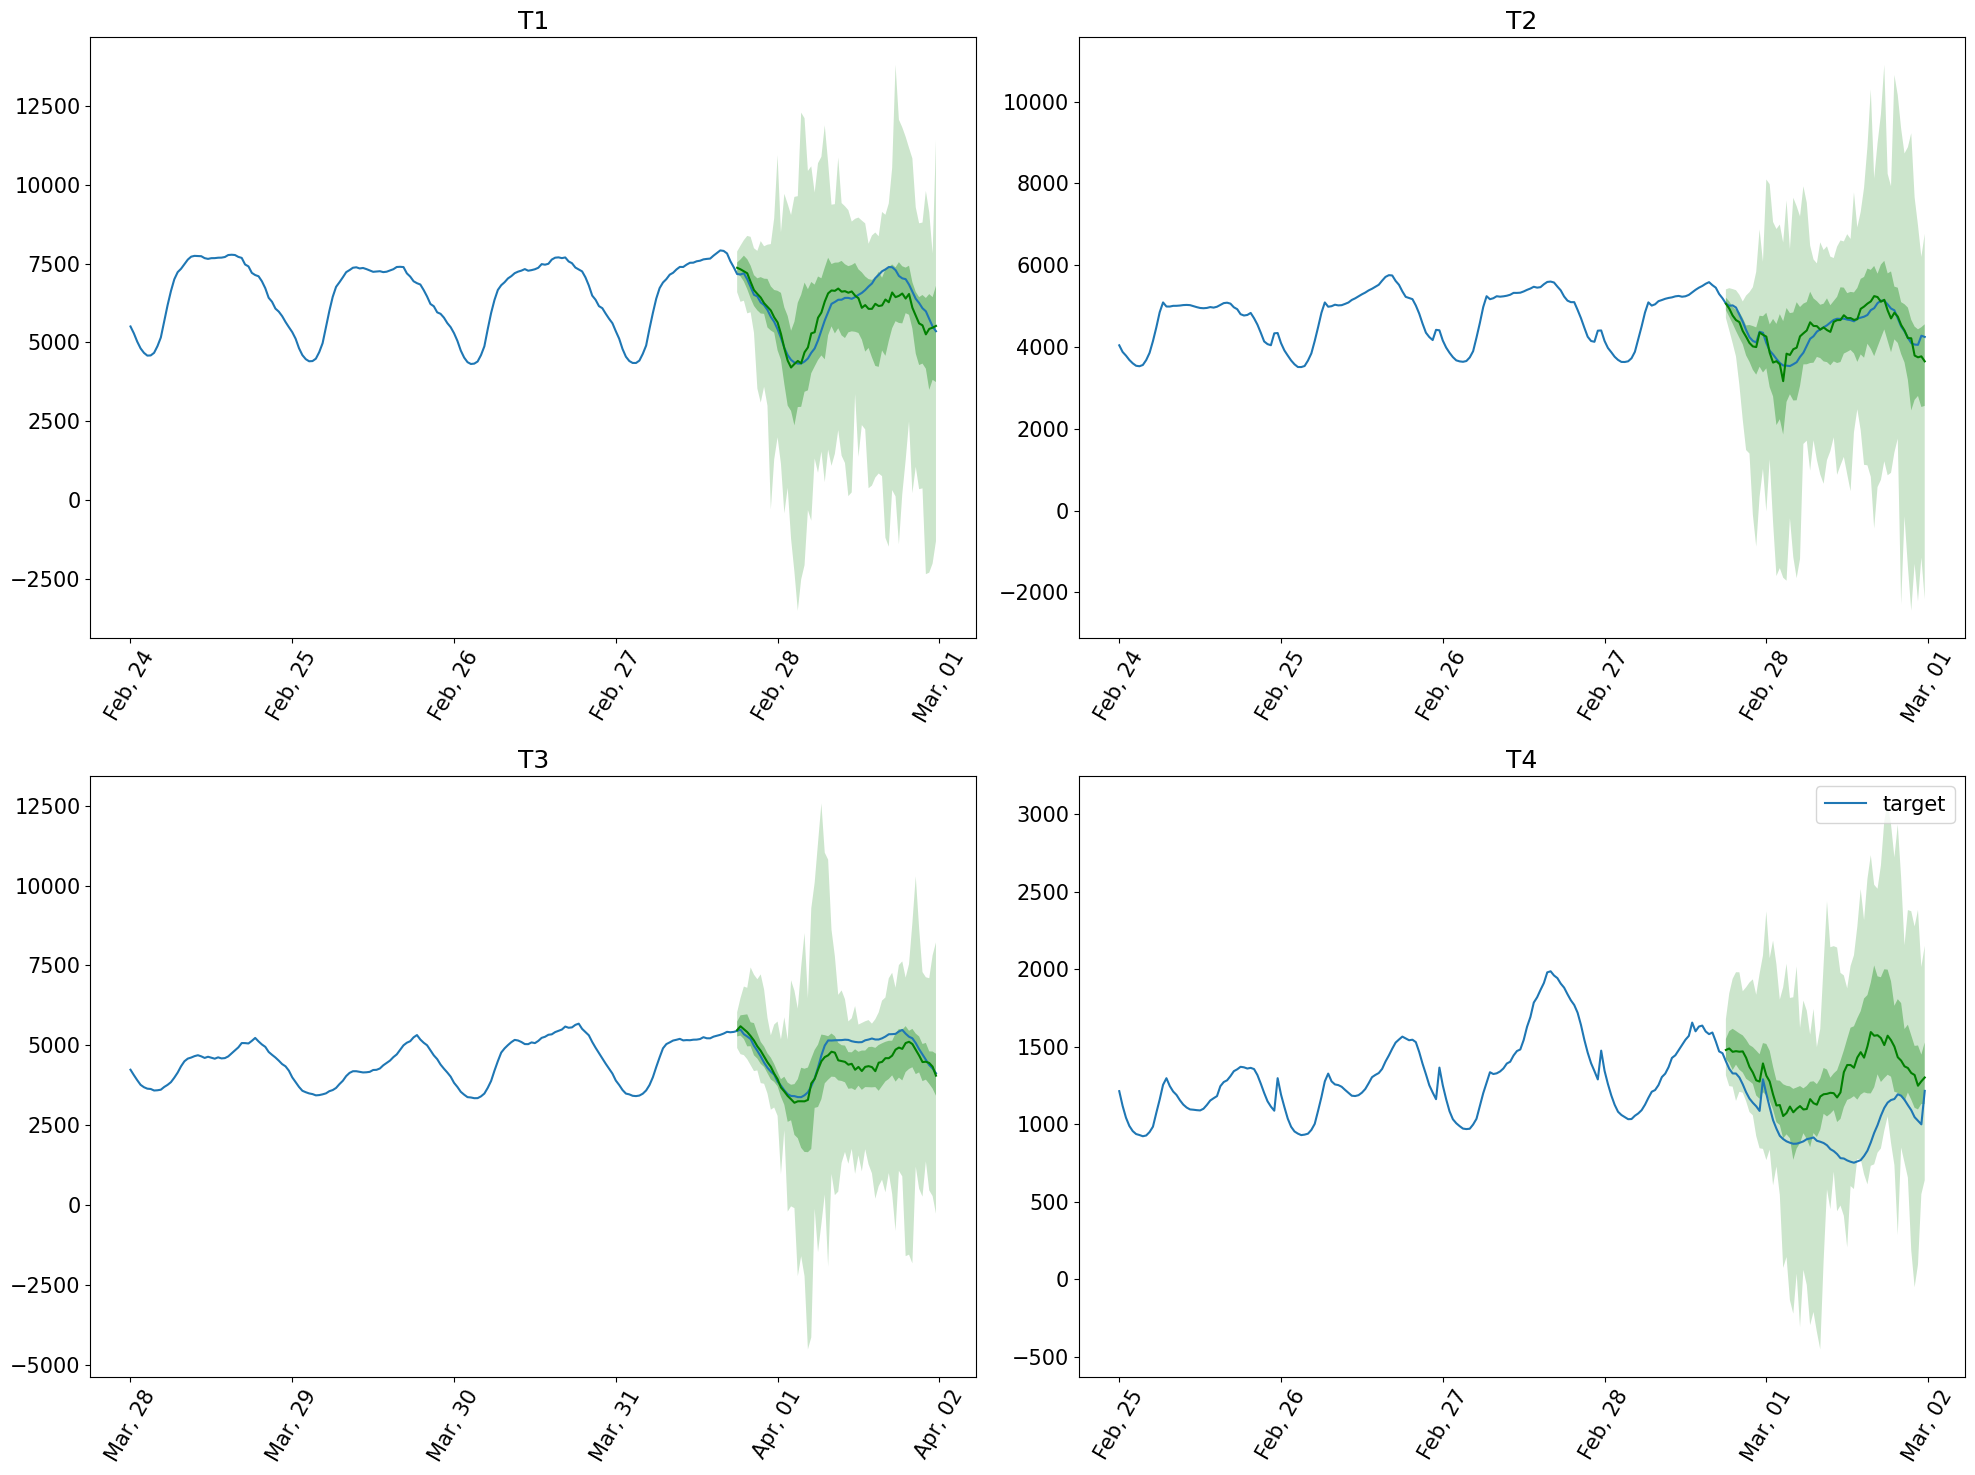

In [ ]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 4):
  ax = plt.subplot(2, 2, idx+1)
  plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target")
  forecast.plot( color='g')

  plt.xticks(rotation=60)
  ax.xaxis.set_major_formatter(date_formater)
  ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [ ]:
len(tss)

5

In [ ]:
# solar data
backtest_dataset = solar_data.test

In [ ]:
prediction_length = solar_data.metadata.prediction_length
context_length = 3 * prediction_length
print(prediction_length, context_length)

24 72


In [ ]:

estimator = LagLlamaEstimator(
    ckpt_path="lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,

    # estimator args
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
)

lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

# doing the same on solar data
forecast_it, ts_it = make_evaluation_predictions(
  dataset=backtest_dataset,
  predictor=predictor)

In [ ]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [ ]:
evaluator = Evaluator()

agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
agg_metrics